# Comparison with FAISS implementation

Installing the required libraries:

In [1]:
!apt install libomp-dev
!pip install faiss-cpu --no-cache
!pip install scikit-fda
!pip install pyclustering

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 0s (3,288 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 124561 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a

Importing the required libraries:

In [2]:
import faiss
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr
from search_approaches import PQ, ExactSearch
from utils import *

Defining constants:

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall" # "siftsmall", "sift", "glove"
SEARCH_TRAIN_SUBSET = False # True if vectors to search in are a subset of the training set
M = 20 if DATASET == "glove" else 8
K = 256

Loading the data.

NOTE: GloVe embeddings are normalized to have unit norm, ensuring that the squared Euclidean distance is proportional to cosine similarity (commonly used for comparing word embeddings), differing only by a constant factor.

In [4]:
tr_data, search_data, queries, gt = load_data(
    dataset_name=DATASET,
    dataset_dir="/content",
    search_train_subset=SEARCH_TRAIN_SUBSET,
    random_seed=RANDOM_SEED
)

print("Base vectors (to search in) shape: ", search_data.shape)
print("Query vectors shape: ", queries.shape)
print("Learn vectors shape: ", tr_data.shape)

sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))

Base vectors (to search in) shape:  (10000, 128)
Query vectors shape:  (100, 128)
Learn vectors shape:  (25000, 128)


Training the quantizers:

In [5]:
pq_faiss = faiss.ProductQuantizer(tr_data.shape[1], M, int(np.log2(K)))
pq_faiss.train(tr_data)
faiss_compressed_tr = pq_faiss.compute_codes(tr_data)
faiss_decompressed_tr = pq_faiss.decode(faiss_compressed_tr)
faiss_rec_error = NMSE(tr_data, faiss_decompressed_tr)

pq_mine = PQ(M=M, K=K, seed=RANDOM_SEED)
pq_mine.train(tr_data, add=False)
mine_compressed_tr = pq_mine.compress(tr_data)
mine_decompressed_tr = pq_mine.decompress(mine_compressed_tr)
mine_rec_error = NMSE(tr_data, mine_decompressed_tr)

Computing recall@R for various values of R on the set of queries:

In [6]:
pq_faiss = faiss.IndexPQ(tr_data.shape[1], M, int(np.log2(K)))
pq_faiss.train(tr_data)
pq_faiss.add(search_data)

pq_mine.add(search_data)

es = ExactSearch(search_data)

ranks_faiss_pq = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)
ranks_mine_pq = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)
ranks_exact = np.zeros((queries.shape[0], search_data.shape[0]), dtype=int)

R = [1, 2, 5, 10, 25, 50, 100]
faiss_recall = np.zeros((len(queries), len(R)))
mine_recall = np.zeros((len(queries), len(R)))

for i, query in enumerate(queries):
  d_faiss, rank_faiss_pq = pq_faiss.search(query.reshape(1, -1), search_data.shape[0])
  ranks_faiss_pq[i] = rank_faiss_pq[0]

  d_mine, rank_mine_pq = pq_mine.search(query, subset=None, asym=True, correct=False)
  ranks_mine_pq[i] = rank_mine_pq

  d_exact, rank_exact = es.search(query)
  ranks_exact[i] = rank_exact

  for j, r in enumerate(R):
    faiss_recall[i][j] = rank_exact[0] in rank_faiss_pq[0][:r]
    mine_recall[i][j] = rank_exact[0] in rank_mine_pq[:r]

faiss_recall_mean = np.mean(faiss_recall, axis=0)
mine_recall_mean = np.mean(mine_recall, axis=0)

Plotting the result:

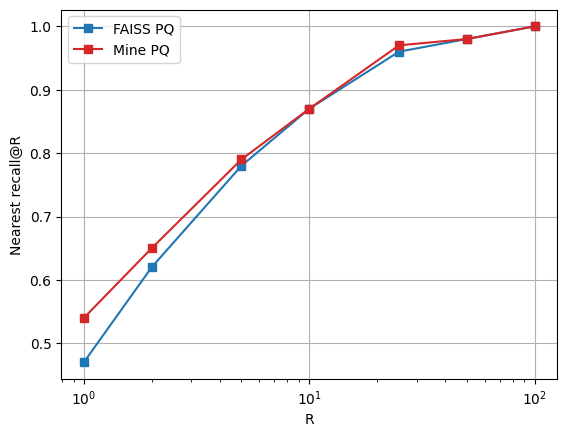

In [7]:
plt.plot(R, faiss_recall_mean, '-s', label="FAISS PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, mine_recall_mean, '-s', label="Mine PQ", color=matplotlib.colormaps["tab20"](6))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Nearest recall@R')
plt.legend()
plt.grid()

Displaying the reconstruction error and the recall@10 for the two implementations:

In [11]:
pd.DataFrame({
    "Reconstruction error on training data (NMSE)": [mine_rec_error, faiss_rec_error],
    "Recall@5": [mine_recall_mean[2], faiss_recall_mean[2]],
    "Recall@10": [mine_recall_mean[3], faiss_recall_mean[3]]
}, index=["Mine", "FAISS"]).style.background_gradient(cmap='Blues')

,Reconstruction error on training data (NMSE),Recall@5,Recall@10
Mine,0.089334,0.790000,0.870000
FAISS,0.089910,0.780000,0.870000


Defining a function to convert the array of document ids sorted by distance to a ranking:

In [9]:
def sorted2rank(sorted):
  ranking = np.zeros(len(sorted))
  for i, el in enumerate(sorted):
      ranking[el] = i+1
  return ranking

Computing the average kendall tau and spearman correlation between the rankings:

In [10]:
kendalls_pq = np.zeros(queries.shape[0])
spearmans_pq = np.zeros(queries.shape[0])

for i in range(queries.shape[0]):
  sorted_mine_pq = sorted2rank(ranks_mine_pq[i])
  sorted_faiss_pq = sorted2rank(ranks_faiss_pq[i])

  kendalls_pq[i], _ = kendalltau(sorted_mine_pq, sorted_faiss_pq)
  spearmans_pq[i], _ = spearmanr(sorted_mine_pq, sorted_faiss_pq)

pd.DataFrame({
    "Average kendall": np.mean(kendalls_pq),
    "Average spearman": np.mean(spearmans_pq),
}, index=[0])

,Average kendall,Average spearman
0,0.873399,0.977495
